In [1]:
!pip install gcm-filters
!pip install xhistogram==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:32841")
client

<Client: 'tcp://127.0.0.1:32841' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:33833' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [6]:
orca01w = cat.ORCA36(region='1',datatype='interior_daily', season='fma'
                    ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),depthu=slice(None,-1),
                                     y=slice(None,450)
                                    ).chunk({'deptht':10,'depthw':10,
                                             'depthv':10,'depthu':10})
orca01s = cat.ORCA36(region='1',datatype='interior_daily', season='aso'
                    ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),depthu=slice(None,-1),
                                     y=slice(None,450)
                                    ).chunk({'deptht':10,'depthw':10,
                                             'depthv':10,'depthu':10})
orca01w

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 46, depthu: 46, depthv: 46, depthw: 47, time_counter: 89, x: 361, y: 450)
Coordinates:
  * deptht                (deptht) float32 0.5058 1.556 2.668 ... 856.7 947.4
  * depthu                (depthu) float32 0.5058 1.556 2.668 ... 856.7 947.4
  * depthv                (depthv) float32 0.5058 1.556 2.668 ... 856.7 947.4
  * depthw                (depthw) float32 0.0 1.024 2.103 ... 814.1 901.1 995.7
    nav_lat               (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2014-02-01T12:00:00 ....
    time_instant          (time_counter) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds, x, y
Data variables: (12/22)
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    depthu_bounds         (depthu, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    depthv_bounds         (depthv, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    depthw_bounds         (depthw, axis_nbounds) float32 dask.array<chunksize=(10, 2), meta=np.ndarray>
    difvho                (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 10, 450, 361), meta=np.ndarray>
    e3t                   (time_counter, deptht, y, x) float32 dask.array<chunksize=(2, 10, 450, 361), meta=np.ndarray>
    ...                    ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_instant_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    uo                    (time_counter, depthu, y, x) float32 dask.array<chunksize=(2, 10, 450, 361), meta=np.ndarray>
    vo                    (time_counter, depthv, y, x) float32 dask.array<chunksize=(2, 10, 450, 361), meta=np.ndarray>
    wo                    (time_counter, depthw, y, x) float32 dask.array<chunksize=(2, 10, 450, 361), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    NCO:                       "4.6.2"
    description:               ocean T grid variables
    history:                   Wed Jun 23 15:18:24 2021: ncks -O -F -d deptht...
    nco_openmp_thread_number:  1
    title:                     ocean T grid variables
    uuid:                      d5c5d033-89d4-49e9-9626-748d94a29c1f

In [7]:
orca01_grid = cat.ORCA36(region='1',datatype='grid',grid='meshmask'
                        ).to_dask().isel(time_counter=0,nav_lev=slice(None,46),y=slice(None,450))
orca01_grid

<xarray.Dataset>
Dimensions:       (nav_lev: 46, x: 361, y: 450)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 773.4 856.7 947.4
    time_counter  float64 0.0
Dimensions without coordinates: x, y
Data variables: (12/50)
    e1f           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e1t           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e1u           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e1v           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e2f           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e2t           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    ...            ...
    tmask         (nav_lev, y, x) int8 dask.array<chunksize=(46, 450, 361), meta=np.ndarray>
    tmaskutil     (y, x) int8 dask.array<chunksize=(450, 361), meta=np.ndarray>
    umask         (nav_lev, y, x) int8 dask.array<chunksize=(46, 450, 361), meta=np.ndarray>
    umaskutil     (y, x) int8 dask.array<chunksize=(450, 361), meta=np.ndarray>
    vmask         (nav_lev, y, x) int8 dask.array<chunksize=(46, 450, 361), meta=np.ndarray>
    vmaskutil     (y, x) int8 dask.array<chunksize=(450, 361), meta=np.ndarray>
Attributes:
    NCO:        "4.6.2"
    TimeStamp:  11/02/2021 04:31:39 -0000
    file_name:  mesh_mask.nc
    history:    Mon Jun 21 12:11:40 2021: ncks -O -F -d x,7526,7886 -d y,5884...

In [8]:
ww = xr.DataArray(.5*(orca01w.wo.isel(depthw=slice(1,None)).fillna(0.).data 
                      + orca01w.wo.isel(depthw=slice(None,-1)).fillna(0.).data
                     ),
                  dims=['time_counter','deptht','y','x'],
                  coords={'time_counter':orca01w.time_counter.data, 'deptht':orca01w.deptht,
                          'y':np.arange(len(orca01w.y)),
                          'x':np.arange(len(orca01w.x))}
                 ).chunk({'deptht':10})

In [8]:
grav = 9.81
w_path = f'{SCRATCH}/region01/ORCA36/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0


bw = -xr.DataArray(sig0w.isel(deptht=slice(None,-1)).where(xr.DataArray(orca01_grid.tmask.data,
                                                                    dims=['deptht','y','x'])!=0.).data,
                   dims=['time_counter','deptht','y','x'],
                   coords={'time_counter':orca01w.time_counter.data, 'deptht':orca01w.deptht,
                           'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}
                  ).chunk({'deptht':10}) * grav / 1e3

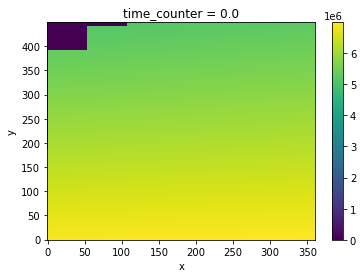

In [9]:
area = (orca01_grid.e1t * orca01_grid.e2t)

area.plot()

In [11]:
dxw = xr.DataArray(orca01_grid.e1u.data, dims=['y','x'],
                   coords={'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(orca01_grid.e2u.data, dims=['y','x'],
                   coords={'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(orca01_grid.e1v.data, dims=['y','x'],
                   coords={'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(orca01_grid.e2v.data, dims=['y','x'],
                   coords={'y':np.arange(len(orca01w.y)),
                           'x':np.arange(len(orca01w.x))}
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'getitem-d786e07307f018e9e77f3bf67e9cea73' (y: 450, x: 361)>
dask.array<getitem, shape=(450, 361), dtype=float64, chunksize=(450, 361), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 441 442 443 444 445 446 447 448 449
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359 360

In [10]:
dx_min = min(orca01_grid.e1u.where(orca01_grid.e1u>0.).min(['y','x']), 
             orca01_grid.e2u.where(orca01_grid.e2u>0.).min(['y','x']),
             orca01_grid.e1v.where(orca01_grid.e1v>0.).min(['y','x']), 
             orca01_grid.e2v.where(orca01_grid.e2v>0.).min(['y','x'])
            )
dx_min = dx_min.values
dx_min

array(2163.97858951)

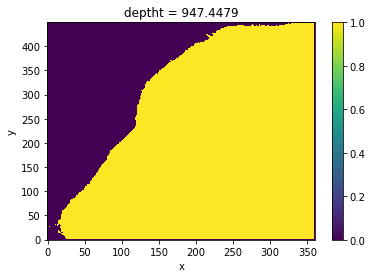

In [12]:
wet_mask = xr.DataArray(np.zeros_like(orca01_grid.tmask),
                        dims=['deptht','y','x'],
                        coords={'deptht':orca01w.deptht,
                                'y':np.arange(len(orca01w.y)),
                                'x':np.arange(len(orca01w.x))}
           )
wet_mask[:,1:-1,1:-1] = orca01_grid.tmask[:,1:-1,1:-1].data.astype(np.float64)

wet_mask.isel(deptht=-1).plot()

In [18]:
kappa_w = xr.ones_like(wet_mask)

kappa_s = xr.ones_like(wet_mask)

In [21]:
filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'y':-1,'x':-1}), 
        'dxw': dxw.chunk({'y':-1,'x':-1}), 'dyw': dyw.chunk({'y':-1,'x':-1}), 
        'dxs': dxs.chunk({'y':-1,'x':-1}), 'dys': dys.chunk({'y':-1,'x':-1}), 
        'area': area.chunk({'y':-1,'x':-1}), 
        'kappa_w': kappa_w.chunk({'y':-1,'x':-1}), 'kappa_s': kappa_s.chunk({'y':-1,'x':-1})
    }
)
filter_30km

Filter(filter_scale=30000.0, dx_min=array(2163.97858951), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=16, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [22]:
bm = filter_30km.apply(bw.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

In [10]:
At = (orca01_grid.e1t * orca01_grid.e2t)
Au = (orca01_grid.e1u * orca01_grid.e2u)
Av = (orca01_grid.e1v * orca01_grid.e2v)
e1u = orca01_grid.e1u
e2u = orca01_grid.e2u
e1v = orca01_grid.e1v
e2v = orca01_grid.e2v
e2t = orca01_grid.e2t
e1t = orca01_grid.e1t
e3t = xr.DataArray(orca01_grid.e3t_0.data, dims=['deptht','y','x'],
                   coords={'deptht':orca01w.deptht})
e3w = xr.DataArray(orca01_grid.e3w_0, dims=['depthw','y','x'],
                   coords={'depthw':orca01w.depthw.isel(depthw=slice(None,-1))}
                  )

ncoars = 3

In [11]:
MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/ORCA36/MLD_fma.zarr")).MLD
# MLDs = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_aso.zarr")).MLD

In [14]:
MLDw_coar = ((MLDw.isel(y=slice(1,-1),x=slice(1,-1))
              *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )

In [53]:
bmx = (bm.isel(x=slice(1,None)).data
       + bm.isel(x=slice(None,-1))
      ) * .5
bmy = (bm.isel(y=slice(1,None)).data
       + bm.isel(y=slice(None,-1))
      ) * .5
dbmx = bmx.diff(dim='x') * e1u.isel(x=slice(1,-1))**-1
dbmy = bmy.diff(dim='y') * e2v.isel(y=slice(1,-1))**-1
M2 = np.sqrt(dbmx.isel(y=slice(1,-1))**2 + dbmy.isel(x=slice(1,-1))**2)
print(M2)

<xarray.DataArray (time_counter: 89, deptht: 46, y: 448, x: 359)>
dask.array<sqrt, shape=(89, 46, 448, 359), dtype=float64, chunksize=(2, 10, 448, 359), chunktype=numpy.ndarray>
Coordinates:
  * y             (y) int64 1 2 3 4 5 6 7 8 ... 441 442 443 444 445 446 447 448
  * x             (x) int64 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * time_counter  (time_counter) datetime64[ns] 2014-02-01T12:00:00 ... 2014-...
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 773.4 856.7 947.4


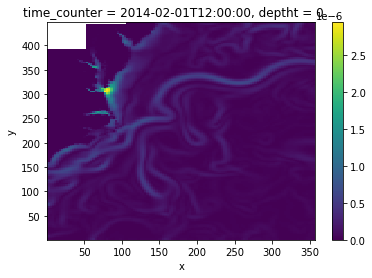

In [54]:
dbmx_coar = ((dbmx.isel(y=slice(1,-1))
              *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )
dbmy_coar = ((dbmy.isel(x=slice(1,-1))
              *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )
M2_coar = ((M2.where(M2.deptht<=MLDw.isel(y=slice(1,-1),x=slice(1,-1)))
            * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)
           * At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                         boundary='trim').sum(skipna=True)**-1
          )
M2_coar.isel(time_counter=0,deptht=0).plot()

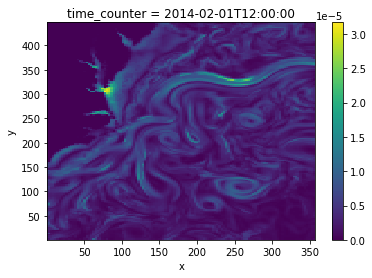

In [55]:
dbmy_coarH = (dbmy_coar
              * e3t.where(e3t.deptht<=MLDw).isel(y=slice(1,-1),x=slice(1,-1)
                                                ).coarsen({'y':ncoars,'x':ncoars},
                                    boundary='trim').mean(skipna=True)
             ).sum('deptht', skipna=True)
dbmx_coarH = (dbmx_coar
              * e3t.where(e3t.deptht<=MLDw).isel(y=slice(1,-1),x=slice(1,-1)
                                                ).coarsen({'y':ncoars,'x':ncoars},
                                    boundary='trim').mean(skipna=True)
             ).sum('deptht', skipna=True)
M2_coarH = (M2_coar 
            * e3t.where(e3t.deptht<=MLDw).isel(y=slice(1,-1),x=slice(1,-1)
                                              ).coarsen({'y':ncoars,'x':ncoars},
                                    boundary='trim').mean(skipna=True)
           ).sum('deptht', skipna=True)
M2_coarH.isel(time_counter=0).plot()

In [55]:
M2_coarb = (M2_coarH 
            / xr.DataArray(e3t.where(e3t.deptht>=MLDw).isel(y=slice(1,-1),x=slice(1,-1))
                          ).coarsen({'y':ncoars,'x':ncoars},
                                    boundary='trim').mean(skipna=True).sum('deptht',skipna=True)
           )
M2_coarb

<xarray.DataArray (time_counter: 89, y: 152, x: 121)>
dask.array<truediv, shape=(89, 152, 121), dtype=float64, chunksize=(3, 15, 32), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * y             (y) float64 4.0 9.0 14.0 19.0 24.0 ... 744.0 749.0 754.0 759.0
  * x             (x) float64 4.0 9.0 14.0 19.0 24.0 ... 589.0 594.0 599.0 604.0
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
    depth         (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e1f           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e1t           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    ...            ...
    e2u           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e2v           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>

In [12]:
import gsw
f = gsw.f(orca01_grid.nav_lat.where(orca01_grid.tmask.isel(nav_lev=0)!=0.
                                   ).isel(y=slice(1,-2),x=slice(1,-2)
                                         ).coarsen({'y':ncoars,'x':ncoars},
                                                   boundary='trim').mean(skipna=True)
         )
mask = orca01_grid.tmask.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                  boundary='trim').mean(skipna=True).reset_coords(drop=True)
mask_coar = xr.DataArray(~np.ma.masked_values(mask,0).mask, 
                         dims=mask.dims,
                         coords=mask.coords)
mask_coar

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<xarray.DataArray (nav_lev: 46, y: 149, x: 119)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
...
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]])
Coordinates:
  * nav_lev  (nav_lev) float32 0.5058 1.556 2.668 3.856 ... 773.4 856.7 947.4
Dimensions without coordinates: y, x

In [57]:
tmp_path = f'{SCRATCH}/region01/ORCA36/'+f'MLI-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
(M2_coarH**2 / f).where(mask_coar.isel(nav_lev=23)!=0.
                       ).reset_coords(drop=True).chunk({'y':-1,'x':-1}).to_dataset(name='MLI').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/ORCA36/MLI-30km_z0-MLD_fma.zarr


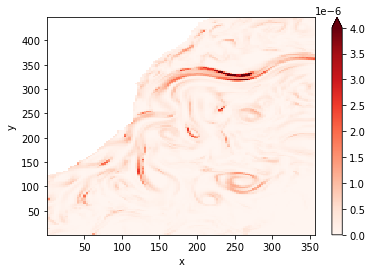

In [58]:
(M2_coarH**2
 / f).isel(time_counter=0).where(mask_coar.isel(nav_lev=23)!=0.).plot(cmap='Reds', vmin=0, vmax=4e-6)

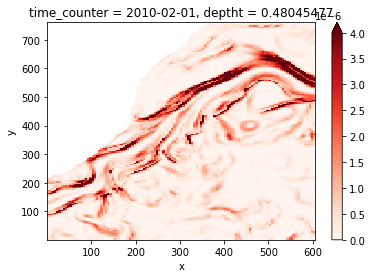

In [76]:
((dbmy_coarH**2 + dbmx_coarH**2)
 / f).isel(time_counter=0).where(depth_coar>1e2).plot(cmap='Reds', vmin=0, vmax=4e-6)

In [13]:
wpbp = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/ORCA36/wb-30km_z0-MLD_fma.zarr")).wpbp

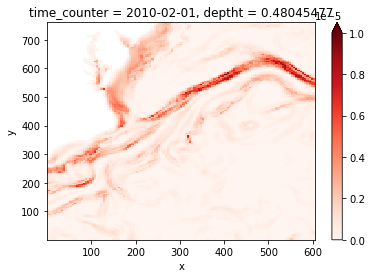

In [64]:
(M2_coarH**2
 / f * boost).isel(time_counter=0).plot(cmap='Reds', vmin=0, vmax=1e-5)

In [14]:
MLI = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/ORCA36/MLI-30km_z0-MLD_fma.zarr")).MLI
wpbp_coar = ((wpbp * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                                   boundary='trim').sum(skipna=True)
             * At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)**-1
            ).where(mask_coar.isel(nav_lev=23)!=0.)

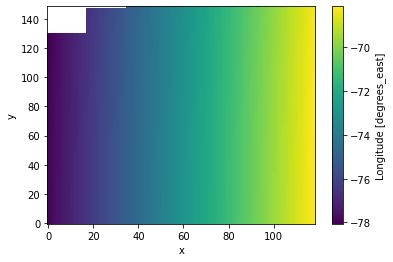

In [15]:
lat_coar = orca01w.nav_lat.where(orca01w.nav_lat>0.).isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                  boundary='trim').mean(skipna=True).reset_coords(drop=True)
lon_coar = orca01w.nav_lon.where(orca01w.nav_lon<-40.).isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                  boundary='trim').mean(skipna=True).reset_coords(drop=True)
lon_coar.plot()

In [16]:
Ce = (wpbp_coar / MLI).compute()
Ce.name = 'Ce'

/tmp/ipykernel_4860/295635179.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(lon_coar, lat_coar, Ce.isel(time_counter=0),
/tmp/ipykernel_4860/295635179.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(lon_coar, lat_coar,


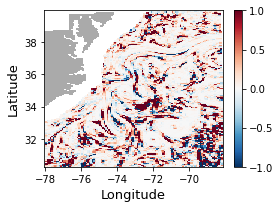

In [37]:
fig, ax = plt.subplots(figsize=(4,3))
fig.set_tight_layout(True)

im = ax.pcolor(lon_coar, lat_coar, Ce.isel(time_counter=0),
               vmin=-1, vmax=1, cmap='RdBu_r', rasterized=True)

ax.pcolor(lon_coar, lat_coar, 
          np.ma.masked_array(mask[0], mask[0]),
          vmin=-1, vmax=2, cmap='binary', rasterized=True)

ax.set_xlabel(r"Longitude", fontsize=13)
ax.set_ylabel(r"Latitude", fontsize=13)
fig.colorbar(im, ax=ax)

plt.savefig('/home/jovyan/Figures/ORCA36-Ce_01.pdf')

In [17]:
alpha = np.ones(len(MLI.time_counter))
for i in range(len(MLI.time_counter)):
    histo = xhist(Ce.isel(time_counter=i),
                  bins=[np.logspace(-4,2,100)
                       ]
                 )
    ix = np.argmax(histo.values)
    alpha[i] = histo.Ce_bin[ix]

aMLI = alpha[:,np.newaxis,np.newaxis]*MLI
aMLI.name = 'MLI'
wpbp_coar.name = 'wpbp'

In [18]:
alphame = (Ce).median(['y','x'],skipna=True).compute()

ameMLI = alphame*MLI
ameMLI.name = 'MLI'

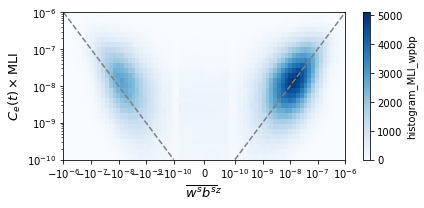

In [36]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist((aMLI).chunk({'time_counter':1}), 
      wpbp_coar.chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/ORCA36-wb_modeCe-hist_01.pdf')

In [19]:
time = np.arange('2014-02', '2014-05', dtype='datetime64[D]')
time

array(['2014-02-01', '2014-02-02', '2014-02-03', '2014-02-04',
       '2014-02-05', '2014-02-06', '2014-02-07', '2014-02-08',
       '2014-02-09', '2014-02-10', '2014-02-11', '2014-02-12',
       '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16',
       '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20',
       '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24',
       '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',
       '2014-03-01', '2014-03-02', '2014-03-03', '2014-03-04',
       '2014-03-05', '2014-03-06', '2014-03-07', '2014-03-08',
       '2014-03-09', '2014-03-10', '2014-03-11', '2014-03-12',
       '2014-03-13', '2014-03-14', '2014-03-15', '2014-03-16',
       '2014-03-17', '2014-03-18', '2014-03-19', '2014-03-20',
       '2014-03-21', '2014-03-22', '2014-03-23', '2014-03-24',
       '2014-03-25', '2014-03-26', '2014-03-27', '2014-03-28',
       '2014-03-29', '2014-03-30', '2014-03-31', '2014-04-01',
       '2014-04-02', '2014-04-03', '2014-04-04', '2014-

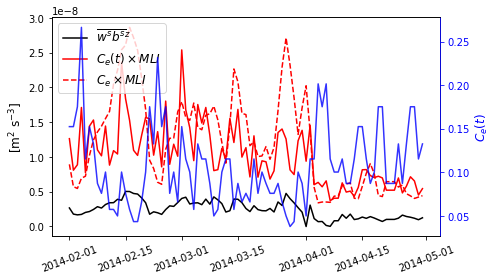

In [48]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, wpbp_coar.median(['y','x'],skipna=True), c='k', label=r"$\overline{w^sb^s}^z$")
ax.plot(time, aMLI.median(['y','x'],skipna=True), c='r', label=r'$C_e(t) \times MLI$')
ax.plot(time, (alpha.mean()*MLI).median(['y','x'],skipna=True), c='r', ls='--', label=r'$C_e \times MLI$')

ax2.plot(time, alpha, c='b', alpha=.8)

ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=12)
ax.set_xticks(['2014-02-01','2014-02-15','2014-03-01','2014-03-15','2014-04-01','2014-04-15','2014-05-01'])
ax.set_xticklabels(labels=['2014-02-01','2014-02-15','2014-03-01','2014-03-15','2014-04-01','2014-04-15','2014-05-01'],
                   rotation=20)
ax2.set_ylabel(r"$C_e(t)$", fontsize=12, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

ax.legend(loc='upper left', fontsize=12)
plt.savefig('/home/jovyan/Figures/ORCA36-wb_modeCe-timeseries_01.pdf')

/tmp/ipykernel_6222/1151577023.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolor(lon_coar, lat_coar, wpbp_coar.isel(time_counter=0), vmin=-1e-7, vmax=1e-7, cmap='seismic', rasterized=True)
/tmp/ipykernel_6222/1151577023.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolor(lon_coar, lat_coar, aMLI.isel(time_counter=0), vmin=0., vmax=1e-7, cmap='Reds', rasterized=True)
/tmp/ipykernel_6222/1151577023.py:7: MatplotlibDeprecatio

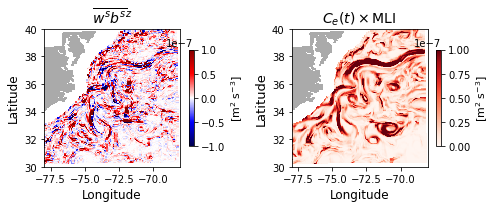

In [47]:
fig, (ax1,ax2) = plt.subplots(figsize=(7,3),nrows=1,ncols=2)
fig.set_tight_layout(True)

im1 = ax1.pcolor(lon_coar, lat_coar, wpbp_coar.isel(time_counter=0), vmin=-1e-7, vmax=1e-7, cmap='seismic', rasterized=True)
im2 = ax2.pcolor(lon_coar, lat_coar, aMLI.isel(time_counter=0), vmin=0., vmax=1e-7, cmap='Reds', rasterized=True)

ax1.pcolor(lon_coar, lat_coar, 
           np.ma.masked_array(mask[0], mask[0]),
           vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax2.pcolor(lon_coar, lat_coar, 
           np.ma.masked_array(mask[0], mask[0]),
           vmin=-1, vmax=2, cmap='binary', rasterized=True)

ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])
ax2.set_xlim([-78,-68])
ax2.set_ylim([30,40])

ax1.set_title(r"$\overline{w^sb^s}^z$", fontsize=14)
ax1.set_xlabel(r"Longitude", fontsize=12)
ax1.set_ylabel(r"Latitude", fontsize=12)
ax2.set_title(r"$C_e(t)\times$MLI", fontsize=14)
ax2.set_xlabel(r"Longitude", fontsize=12)
ax2.set_ylabel(r"Latitude", fontsize=13)

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-3}$]", fontsize=11)
cbar2.set_label(r"[m$^2$ s$^{-3}$]", fontsize=11)

plt.savefig('/home/jovyan/Figures/ORCA36-wb-hist_01.pdf')

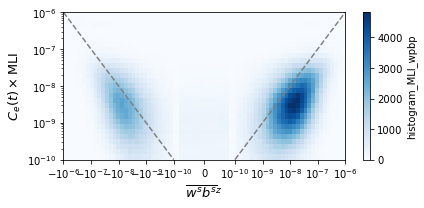

In [41]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist((ameMLI).chunk({'time_counter':1}), 
      wpbp_coar.chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/ORCA36-wb_medianCe-hist_01.pdf')

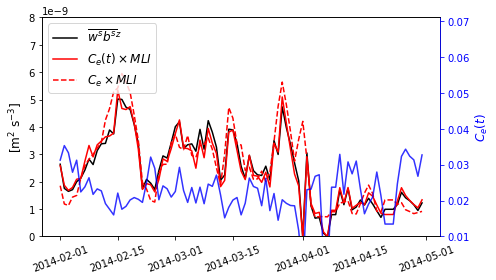

In [20]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, wpbp_coar.median(['y','x'],skipna=True), c='k', label=r"$\overline{w^sb^s}^z$")
ax.plot(time, ameMLI.median(['y','x'],skipna=True), c='r', label=r'$C_e(t) \times MLI$')
ax.plot(time, (alphame.mean('time_counter')*MLI).median(['y','x'],skipna=True), c='r', ls='--', label=r'$C_e \times MLI$')

ax2.plot(time, alphame, c='b', alpha=.8)

ax.set_ylim([0,8e-9])
ax2.set_ylim([.01,.071])
ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=12)
ax.set_xticks(['2014-02-01','2014-02-15','2014-03-01','2014-03-15','2014-04-01','2014-04-15','2014-05-01'])
ax.set_xticklabels(labels=['2014-02-01','2014-02-15','2014-03-01','2014-03-15','2014-04-01','2014-04-15','2014-05-01'],
                   rotation=20)
ax2.set_ylabel(r"$C_e(t)$", fontsize=12, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

ax.legend(loc='upper left', fontsize=12)
plt.savefig('/home/jovyan/Figures/ORCA36-wb-timeseries_01.pdf')

In [25]:
alpham = (Ce).mean(['y','x'],skipna=True)

amMLI = alpham*MLI
amMLI.name = 'MLI'

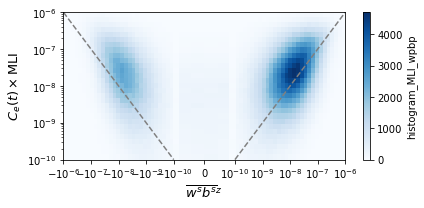

In [33]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist((amMLI).chunk({'time_counter':1}), 
      wpbp_coar.chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/ORCA36-wb_meanCe-hist_01.pdf')

In [28]:
alpha75 = np.ones(len(MLI.time_counter))
for i in range(len(MLI.time_counter)):
    alpha75[i] = np.quantile(np.ma.masked_invalid((Ce).isel(time_counter=i)).compressed(), 
                             .75
                            )

a75MLI = alpha75[:,np.newaxis,np.newaxis]*MLI
a75MLI.name = 'MLI'

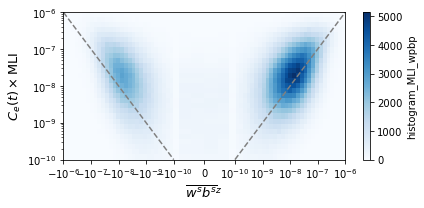

In [34]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist((a75MLI).chunk({'time_counter':1}), 
      wpbp_coar.chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/ORCA36-wb_075Ce-hist_01.pdf')

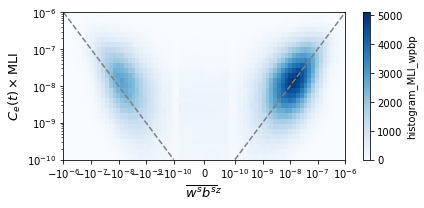

In [40]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist((aMLI).chunk({'time_counter':1}), 
      wpbp_coar.chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/ORCA36-wb_modeCe-hist_01.pdf')